In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip -uq "/content/drive/My Drive/Colab Notebooks/A_05_Part_02_Dataset.zip" -d "/content/drive/My Drive"

In [0]:
data_dir = '/content/drive/My Drive/A5Dataset'
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

BATCH_SIZE=64
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
def to_onehot(labels, n_categories):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories))
    for i, label in enumerate(labels):
        if label==0:
          label = torch.LongTensor([0,2])
        else:
          label = torch.LongTensor([label])
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

def decode(labels):
    decoded = torch.zeros(size=(len(labels), 1)).to(device)
    for i, label in enumerate(labels):
        if torch.eq(label,torch.tensor([1., 0., 1.],device=device)).all():
          decoded[i] = 0
        elif torch.eq(label,torch.tensor([0., 1., 0.],device=device)).all():
          decoded[i] = 1
        elif torch.eq(label,torch.tensor([0., 0., 1.],device=device)).all():
          decoded[i] = 2
        else:
          decoded[i] = 3
    return decoded
def plot_curve(array,title, ylabel):
  plt.figure()
  plt.plot(array,'o', color="r",marker='o',linestyle='-',
                  linewidth=2,markersize=12)
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.title(title)

In [0]:
class ImageFolderWithNames(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithNames, self).__getitem__(index)
        imgName = self.imgs[index][0]
        tuple_with_imgName = (original_tuple + (imgName,))
        return tuple_with_imgName

test_dataset = ImageFolderWithNames(data_dir + '/Test', transform=test_transforms) # our custom dataset
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [0]:
def validationTraining(model, dataloader, critertion, device,focalLoss=False):
    
    model.eval()    
    accuracy = 0
    loss = 0
    gamma=2
    total_predictions = torch.Tensor()
    total_labels = torch.Tensor()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        labels_encoded = to_onehot(labels, n_categories=3)
        labels_encoded = labels_encoded.to(device)

        outputs = model(inputs)             #----> forward pass

        prediction = torch.sigmoid(outputs)
        prediction_encoded = (prediction>0.5).float()

        total_predictions = torch.cat((total_predictions,prediction_encoded.cpu()))
        total_labels = torch.cat((total_labels,labels_encoded.cpu()))
        
        accuracy += accuracy_score(labels_encoded.cpu().numpy(), prediction_encoded.cpu().numpy())
        
        if focalLoss:
          BCEloss = criterion(outputs, labels_encoded)
          pt = torch.exp(-BCEloss)
          loss += ((1-pt)**gamma * BCEloss).mean().item()
        else:
          loss += criterion(outputs, labels_encoded).item()
        
    
    avg_accuracy = (accuracy/len(dataloader))*100.
    mean_loss = (loss/len(dataloader))
    confusion_matrix = multilabel_confusion_matrix(total_labels.numpy(), total_predictions.numpy())
    f1_sc = f1_score(total_labels.numpy(), total_predictions.numpy(), average='weighted')
    
    return avg_accuracy, mean_loss, confusion_matrix, f1_sc

def train(model, dataloader, critertion, optimizer, device, epoch, focalLoss=False):
  
    model.train()  
    
    total_predictions = torch.Tensor()
    total_labels = torch.Tensor()
    running_loss = 0
    accuracy = 0  
    gamma = 2

    for i, data in enumerate(dataloader):    # train loop 
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        labels_encoded = to_onehot(labels, n_categories=3)
        labels_encoded = labels_encoded.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)               #----> forward pass
        
        if focalLoss:
          BCEloss = criterion(outputs, labels_encoded)
          pt = torch.exp(-BCEloss)
          loss = ((1-pt)**gamma * BCEloss).mean()
          loss.backward() 
          running_loss += loss.item()
        else:
          loss = criterion(outputs, labels_encoded)
          loss.backward()
          running_loss += loss.item()

        optimizer.step()                    #----> weights update
        
        prediction = torch.sigmoid(outputs)
        prediction_encoded = (prediction>0.5).float()
        
        total_predictions = torch.cat((total_predictions,prediction_encoded.cpu()))
        total_labels = torch.cat((total_labels,labels_encoded.cpu()))

        accuracy += accuracy_score(labels_encoded.cpu().numpy(), prediction_encoded.cpu().numpy())
    
    avg_accuracy = (accuracy/len(dataloader))*100.
    mean_loss = (running_loss/len(dataloader))
    confusion_matrix = multilabel_confusion_matrix(total_labels.numpy(), total_predictions.numpy())
    f1_sc = f1_score(total_labels.numpy(), total_predictions.numpy(), average='weighted')
    
    return avg_accuracy, mean_loss, confusion_matrix, f1_sc


With Focal Loss

VGG

In [0]:
vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[0].in_features

for param in vgg16.parameters():         # Freeze all conv layers
    param.requires_grad = False
    
num_classes = 3

classifiers = [nn.Linear(num_features, 1000), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(1000, num_classes)]
vgg16.classifier = nn.Sequential(*classifiers)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
train_loss_arr_fc = []
train_acc_arr_fc = []
val_loss_arr_fc = []
val_acc_arr_fc = []
train_confusion_matrix_fc=[]
val_confusion_matrix_fc=[]
train_f1_fc=[]
val_f1_fc=[]

Epochs = 15
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg16.to(device)

best_accuracy_fc=0

for epoch in range(Epochs):
    train_acc, train_loss, train_cf, t_f1 = train(vgg16, trainloader, criterion, optimizer, device, epoch,focalLoss=True)
    val_acc, val_loss, val_cf, v_f1 = validationTraining(vgg16, valloader, criterion, device,focalLoss=True)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr_fc.append(train_loss)
    train_acc_arr_fc.append(train_acc)
    val_loss_arr_fc.append(val_loss)
    val_acc_arr_fc.append(val_acc)
    train_confusion_matrix_fc.append(train_cf)
    val_confusion_matrix_fc.append(val_cf)
    train_f1_fc.append(t_f1)
    val_f1_fc.append(v_f1)

    if val_acc_arr_fc[-1] > best_accuracy_fc:
      best_accuracy_fc = val_acc_arr_fc[-1]
      torch.save(vgg16.state_dict(), './vgg16_focal_loss.pth')

Epoch  0 	            Training Loss: 0.0421	            Training Accuracy: 70.73	            Validation Loss: 0.0211	            Validation Accuracy: 84.00	
Epoch  1 	            Training Loss: 0.0186	            Training Accuracy: 81.87	            Validation Loss: 0.0162	            Validation Accuracy: 84.47	
Epoch  2 	            Training Loss: 0.0151	            Training Accuracy: 82.95	            Validation Loss: 0.0131	            Validation Accuracy: 85.44	
Epoch  3 	            Training Loss: 0.0128	            Training Accuracy: 83.64	            Validation Loss: 0.0116	            Validation Accuracy: 84.99	
Epoch  4 	            Training Loss: 0.0117	            Training Accuracy: 84.07	            Validation Loss: 0.0106	            Validation Accuracy: 86.26	
Epoch  5 	            Training Loss: 0.0105	            Training Accuracy: 84.50	            Validation Loss: 0.0096	            Validation Accuracy: 86.26	
Epoch  6 	            Training Loss: 0.0100	            Tr

Training Confusion Matrix: 
 [[[6000    0]
  [ 189   11]]

 [[1848  352]
  [ 231 3769]]

 [[3766  234]
  [ 345 1855]]]
Validation Confusion Matrix: 
 [[[600   0]
  [ 28   0]]

 [[187  41]
  [ 15 385]]

 [[383  17]
  [ 43 185]]]
Training F1 Score: 
 0.8807350032149353
Validation F1 Score: 
 0.8674807964082794


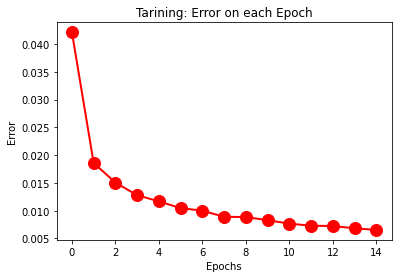

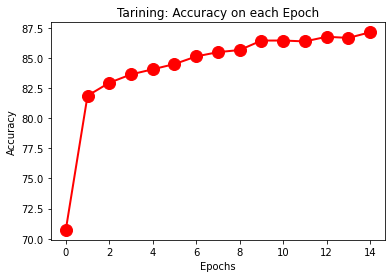

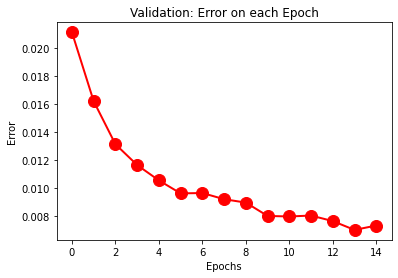

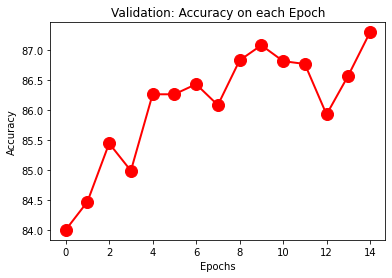

In [0]:
print('Training Confusion Matrix: \n',train_confusion_matrix_fc[-1])
print('Validation Confusion Matrix: \n',val_confusion_matrix_fc[-1])
print('Training F1 Score: \n',train_f1_fc[-1])
print('Validation F1 Score: \n',val_f1_fc[-1])
def plot_curve(array,title, ylabel):
  plt.figure()
  plt.plot(array,'o', color="r",marker='o',linestyle='-',
                  linewidth=2,markersize=12)
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.title(title)

plot_curve(train_loss_arr_fc,'Tarining: Error on each Epoch','Error')
plot_curve(train_acc_arr_fc,'Tarining: Accuracy on each Epoch','Accuracy')
plot_curve(val_loss_arr_fc,'Validation: Error on each Epoch','Error')
plot_curve(val_acc_arr_fc,'Validation: Accuracy on each Epoch','Accuracy')

In [0]:
total_predictions_fc = torch.Tensor()
imageNames_fc = []

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        prediction = torch.sigmoid(outputs)
        prediction_encoded = (prediction>0.5).float()
        
        total_predictions_fc = torch.cat((total_predictions_fc,prediction_encoded.cpu()))
        imageNames_fc.extend([os.path.basename(path) for path in paths])

imageNames_fc = np.array( imageNames_fc ).reshape(len(imageNames_fc),1)
index = [0,2,1]
arranged_predictions_fc = total_predictions_fc.numpy()[:,index]
FinalCSVFile_fc = np.concatenate([imageNames_fc,arranged_predictions_fc],axis=1) 
np.savetxt("MSDS19014_results.csv", FinalCSVFile_fc, delimiter=",", header='image,covid-19,pneumonia,normal', fmt='%s')

RESNET

In [0]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)

# Freeze training for all layers
for param in res18.parameters():
    param.require_grad = False

res18.fc = nn.Sequential(nn.Linear(512, 1000),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(1000, 3),nn.ReLU(inplace=True))


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
train_loss_arr_resnet_fc = []
train_acc_arr_resnet_fc = []
val_loss_arr_resnet_fc = []
val_acc_arr_resnet_fc = []
train_confusion_matrix_resnet_fc=[]
val_confusion_matrix_resnet_fc=[]
train_f1_resnet_fc=[]
val_f1_resnet_fc=[]


Epochs = 15
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

res18.to(device)
best_accuracy_resnet_fc=0

for epoch in range(Epochs):
    train_acc, train_loss, train_cf, t_f1 = train(res18, trainloader, criterion, optimizer, device, epoch,focalLoss=True)
    val_acc, val_loss, val_cf, v_f1 = validationTraining(res18, valloader, criterion, device,focalLoss=True)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr_resnet_fc.append(train_loss)
    train_acc_arr_resnet_fc.append(train_acc)
    val_loss_arr_resnet_fc.append(val_loss)
    val_acc_arr_resnet_fc.append(val_acc)
    train_confusion_matrix_resnet_fc.append(train_cf)
    val_confusion_matrix_resnet_fc.append(val_cf)
    train_f1_resnet_fc.append(t_f1)
    val_f1_resnet_fc.append(v_f1)

    if val_acc_arr_resnet_fc[-1] > best_accuracy_resnet_fc:
      best_accuracy_resnet_fc = val_acc_arr_resnet_fc[-1]
      torch.save(res18.state_dict(), './res18_focal_loss.pth')

Epoch  0 	            Training Loss: 0.1555	            Training Accuracy: 57.89	            Validation Loss: 0.1431	            Validation Accuracy: 63.69	
Epoch  1 	            Training Loss: 0.1385	            Training Accuracy: 62.61	            Validation Loss: 0.1310	            Validation Accuracy: 63.45	
Epoch  2 	            Training Loss: 0.1305	            Training Accuracy: 62.61	            Validation Loss: 0.1259	            Validation Accuracy: 63.29	
Epoch  3 	            Training Loss: 0.1260	            Training Accuracy: 62.47	            Validation Loss: 0.1233	            Validation Accuracy: 63.29	
Epoch  4 	            Training Loss: 0.1232	            Training Accuracy: 62.30	            Validation Loss: 0.1215	            Validation Accuracy: 62.37	
Epoch  5 	            Training Loss: 0.1202	            Training Accuracy: 62.54	            Validation Loss: 0.1205	            Validation Accuracy: 61.96	
Epoch  6 	            Training Loss: 0.1179	            Tr

Training Confusion Matrix: 
 [[[5995    5]
  [ 200    0]]

 [[1816  384]
  [ 111 3889]]

 [[3945   55]
  [2009  191]]]
Validation Confusion Matrix: 
 [[[600   0]
  [ 28   0]]

 [[195  33]
  [ 13 387]]

 [[399   1]
  [216  12]]]
Training F1 Score: 
 0.6412888418857351
Validation F1 Score: 
 0.6101621490863223


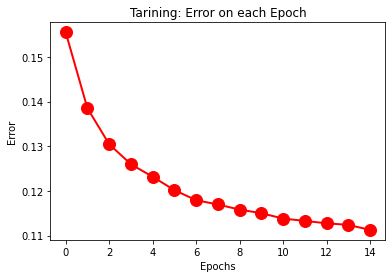

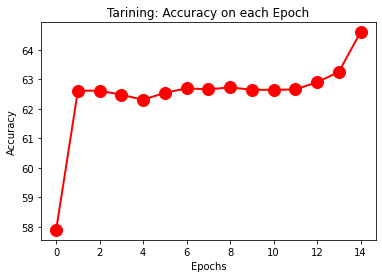

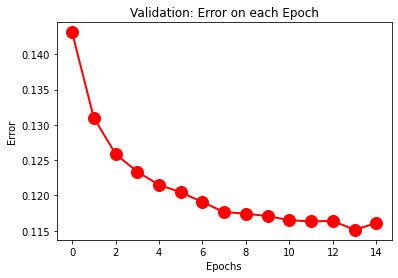

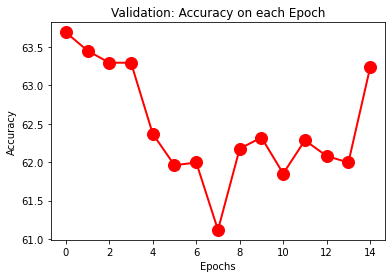

In [0]:
print('Training Confusion Matrix: \n',train_confusion_matrix_resnet_fc[-1])
print('Validation Confusion Matrix: \n',val_confusion_matrix_resnet_fc[-1])
print('Training F1 Score: \n',train_f1_resnet_fc[-1])
print('Validation F1 Score: \n',val_f1_resnet_fc[-1])

plot_curve(train_loss_arr_resnet_fc,'Tarining: Error on each Epoch','Error')
plot_curve(train_acc_arr_resnet_fc,'Tarining: Accuracy on each Epoch','Accuracy')
plot_curve(val_loss_arr_resnet_fc,'Validation: Error on each Epoch','Error')
plot_curve(val_acc_arr_resnet_fc,'Validation: Accuracy on each Epoch','Accuracy')

In [0]:
total_predictions_resnet_fc = torch.Tensor()
imageNames_resnet_fc = []

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)

        prediction = torch.sigmoid(outputs)
        prediction_encoded = (prediction>0.5).float()
        
        total_predictions_resnet_fc = torch.cat((total_predictions_resnet_fc,prediction_encoded.cpu()))
        imageNames_resnet_fc.extend([os.path.basename(path) for path in paths])

imageNames_resnet_fc = np.array( imageNames_resnet_fc ).reshape(len(imageNames_resnet_fc),1)
index = [0,2,1]
arranged_predictions_resnet_fc = total_predictions_resnet_fc.numpy()[:,index]
FinalCSVFile_resnet_fc = np.concatenate([imageNames_resnet_fc,arranged_predictions_resnet_fc],axis=1) 
np.savetxt("MSDS19014_results_resnet_fc.csv", FinalCSVFile_resnet_fc, delimiter=",", header='image,covid-19,pneumonia,normal', fmt='%s')

Without Focal Loss

VGG

In [0]:
vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[0].in_features

for param in vgg16.parameters():         # Freeze all conv layers
    param.requires_grad = False
    
num_classes = 3

classifiers = [nn.Linear(num_features, 1000), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(1000, num_classes)]
vgg16.classifier = nn.Sequential(*classifiers)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []
train_confusion_matrix=[]
val_confusion_matrix=[]
train_f1=[]
val_f1=[]

vgg16.to(device)
best_accuracy=0
for epoch in range(Epochs):
    train_acc, train_loss, train_cf, t_f1 = train(vgg16, trainloader, criterion, optimizer, device, epoch,focalLoss=False)
    val_acc, val_loss, val_cf, v_f1 = validationTraining(vgg16, valloader, criterion, device,focalLoss=False)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    train_confusion_matrix.append(train_cf)
    val_confusion_matrix.append(val_cf)
    train_f1.append(t_f1)
    val_f1.append(v_f1)

    if val_acc_arr[-1] > best_accuracy:
      best_accuracy = val_acc_arr[-1]
      torch.save(vgg16.state_dict(), './vgg16.pth')

Epoch  0 	            Training Loss: 0.3230	            Training Accuracy: 76.38	            Validation Loss: 0.2370	            Validation Accuracy: 85.01	
Epoch  1 	            Training Loss: 0.2226	            Training Accuracy: 85.09	            Validation Loss: 0.2078	            Validation Accuracy: 86.47	
Epoch  2 	            Training Loss: 0.1907	            Training Accuracy: 87.17	            Validation Loss: 0.1960	            Validation Accuracy: 87.02	
Epoch  3 	            Training Loss: 0.1727	            Training Accuracy: 88.66	            Validation Loss: 0.1876	            Validation Accuracy: 88.00	
Epoch  4 	            Training Loss: 0.1605	            Training Accuracy: 89.30	            Validation Loss: 0.1930	            Validation Accuracy: 89.54	
Epoch  5 	            Training Loss: 0.1529	            Training Accuracy: 90.38	            Validation Loss: 0.1780	            Validation Accuracy: 89.12	
Epoch  6 	            Training Loss: 0.1441	            Tr

Training Confusion Matrix: 
 [[[5996    4]
  [  59  141]]

 [[2038  162]
  [  95 3905]]

 [[3916   84]
  [ 168 2032]]]
Validation Confusion Matrix: 
 [[[600   0]
  [ 12  16]]

 [[195  33]
  [ 23 377]]

 [[379  21]
  [ 33 195]]]
Training F1 Score: 
 0.9543114436774749
Validation F1 Score: 
 0.903932295192458


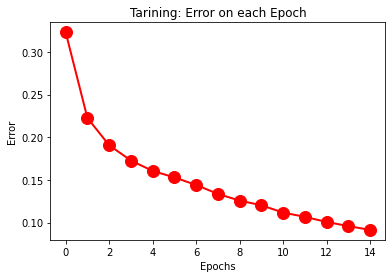

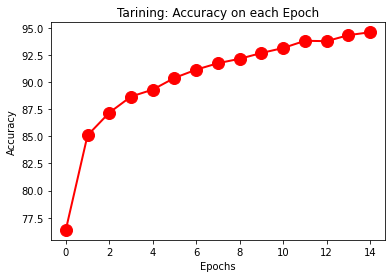

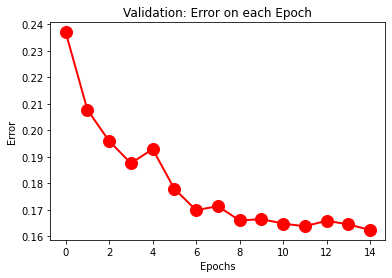

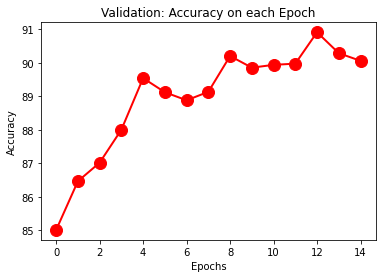

In [0]:
print('Training Confusion Matrix: \n',train_confusion_matrix[-1])
print('Validation Confusion Matrix: \n',val_confusion_matrix[-1])
print('Training F1 Score: \n',train_f1[-1])
print('Validation F1 Score: \n',val_f1[-1])

plot_curve(train_loss_arr,'Tarining: Error on each Epoch','Error')
plot_curve(train_acc_arr,'Tarining: Accuracy on each Epoch','Accuracy')
plot_curve(val_loss_arr,'Validation: Error on each Epoch','Error')
plot_curve(val_acc_arr,'Validation: Accuracy on each Epoch','Accuracy')

In [0]:
total_predictions = torch.Tensor()
imageNames = []

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        prediction = torch.sigmoid(outputs)
        prediction_encoded = (prediction>0.5).float()
        
        total_predictions = torch.cat((total_predictions,prediction_encoded.cpu()))
        imageNames.extend([os.path.basename(path) for path in paths])

imageNames = np.array( imageNames ).reshape(len(imageNames),1)
index = [0,2,1]
arranged_predictions = total_predictions.numpy()[:,index]
FinalCSVFile = np.concatenate([imageNames,arranged_predictions],axis=1) 
np.savetxt("MSDS19014_results_vgg_wfc.csv", FinalCSVFile, delimiter=",", header='image,covid-19,pneumonia,normal', fmt='%s')

RESNET

In [0]:
# Load the pretrained model from pytorch
res18 = models.resnet18(pretrained=True)

# Freeze training for all layers
for param in res18.parameters():
    param.require_grad = False

res18.fc = nn.Sequential(nn.Linear(512, 1000),nn.ReLU(inplace=True),nn.Dropout(p=0.5, inplace=False),nn.Linear(1000, 3),nn.ReLU(inplace=True))

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(res18.parameters(), lr=0.001, momentum=0.9)

In [0]:
train_loss_arr_resnet = []
train_acc_arr_resnet = []
val_loss_arr_resnet = []
val_acc_arr_resnet = []
train_confusion_matrix_resnet=[]
val_confusion_matrix_resnet=[]
train_f1_resnet=[]
val_f1_resnet=[]

res18.to(device)
best_accuracy_resnet=0

for epoch in range(Epochs):
    train_acc, train_loss, train_cf, t_f1 = train(res18, trainloader, criterion, optimizer, device, epoch,focalLoss=False)
    val_acc, val_loss, val_cf, v_f1 = validationTraining(res18, valloader, criterion, device,focalLoss=False)

    print("Epoch {:2d} \t \
           Training Loss: {:.4f}\t \
           Training Accuracy: {:.2f}\t \
           Validation Loss: {:.4f}\t \
           Validation Accuracy: {:.2f}\t".format(epoch,
                                                train_loss, 
                                                train_acc, 
                                                val_loss, 
                                                val_acc))

    train_loss_arr_resnet.append(train_loss)
    train_acc_arr_resnet.append(train_acc)
    val_loss_arr_resnet.append(val_loss)
    val_acc_arr_resnet.append(val_acc)
    train_confusion_matrix_resnet.append(train_cf)
    val_confusion_matrix_resnet.append(val_cf)
    train_f1_resnet.append(t_f1)
    val_f1_resnet.append(v_f1)

    if val_acc_arr_resnet[-1] > best_accuracy_resnet:
      best_accuracy_resnet = val_acc_arr_resnet[-1]
      torch.save(res18.state_dict(), './res18.pth')

Epoch  0 	            Training Loss: 0.6640	            Training Accuracy: 53.90	            Validation Loss: 0.6258	            Validation Accuracy: 63.53	
Epoch  1 	            Training Loss: 0.6170	            Training Accuracy: 63.18	            Validation Loss: 0.6060	            Validation Accuracy: 63.39	
Epoch  2 	            Training Loss: 0.5956	            Training Accuracy: 68.27	            Validation Loss: 0.5743	            Validation Accuracy: 73.49	
Epoch  3 	            Training Loss: 0.5641	            Training Accuracy: 75.22	            Validation Loss: 0.5522	            Validation Accuracy: 80.25	
Epoch  4 	            Training Loss: 0.5475	            Training Accuracy: 80.66	            Validation Loss: 0.5443	            Validation Accuracy: 83.46	
Epoch  5 	            Training Loss: 0.5361	            Training Accuracy: 84.02	            Validation Loss: 0.5367	            Validation Accuracy: 83.62	
Epoch  6 	            Training Loss: 0.5288	            Tr

Training Confusion Matrix: 
 [[[6000    0]
  [ 200    0]]

 [[1992  208]
  [  28 3972]]

 [[3858  142]
  [  82 2118]]]
Validation Confusion Matrix: 
 [[[600   0]
  [ 28   0]]

 [[196  32]
  [ 11 389]]

 [[366  34]
  [ 18 210]]]
Training F1 Score: 
 0.9334536411678929
Validation F1 Score: 
 0.8870903887665603


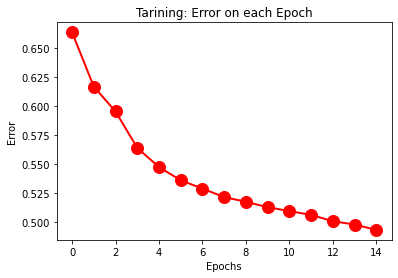

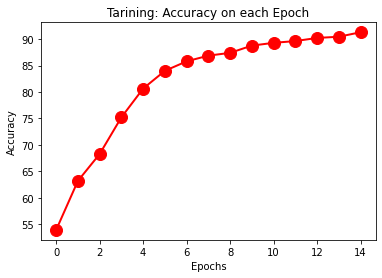

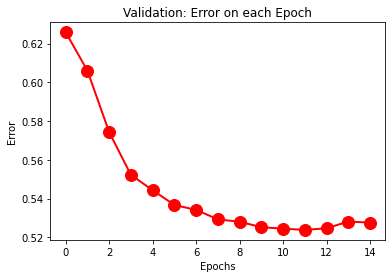

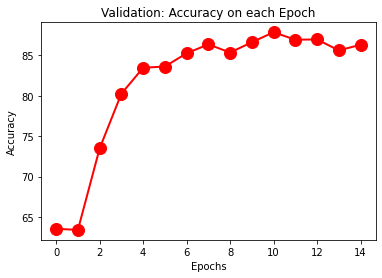

In [0]:
print('Training Confusion Matrix: \n',train_confusion_matrix_resnet[-1])
print('Validation Confusion Matrix: \n',val_confusion_matrix_resnet[-1])
print('Training F1 Score: \n',train_f1_resnet[-1])
print('Validation F1 Score: \n',val_f1_resnet[-1])

plot_curve(train_loss_arr_resnet,'Tarining: Error on each Epoch','Error')
plot_curve(train_acc_arr_resnet,'Tarining: Accuracy on each Epoch','Accuracy')
plot_curve(val_loss_arr_resnet,'Validation: Error on each Epoch','Error')
plot_curve(val_acc_arr_resnet,'Validation: Accuracy on each Epoch','Accuracy')

In [0]:
total_predictions_resnet = torch.Tensor()
imageNames_resnet = []

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        outputs = res18(images)

        prediction = torch.sigmoid(outputs)
        prediction_encoded = (prediction>0.5).float()
        
        total_predictions_resnet = torch.cat((total_predictions_resnet,prediction_encoded.cpu()))
        imageNames_resnet.extend([os.path.basename(path) for path in paths])

imageNames_resnet = np.array( imageNames_resnet ).reshape(len(imageNames_resnet),1)
index = [0,2,1]
arranged_predictions_resnet = total_predictions_resnet.numpy()[:,index]
FinalCSVFile_resnet = np.concatenate([imageNames_resnet,arranged_predictions_resnet],axis=1) 
np.savetxt("MSDS19014_results_resnet_wfc.csv", FinalCSVFile_resnet, delimiter=",", header='image,covid-19,pneumonia,normal', fmt='%s')